In [ ]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-bcfa836f-fa3d-7411-22c5-c5f2f84bc080)


In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import netCDF4
import xarray as xr
import numpy as np
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import joblib

import time

import tensorflow as tf
from tensorflow import keras
from keras.models import load_model, Sequential
from keras.layers import LSTM, Dense, TimeDistributed, Flatten, Dropout, LeakyReLU, RepeatVector, Conv1D, MaxPooling1D

from scipy import ndimage

# !pip install visualkeras
# import visualkeras

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Useful functions

In [ ]:
# Function we use for plotting
def plot_data_img(nr, nc, data, true_data, ts, title='Plot test', name_file=None, threshold=0.01):
    
    valmin = [np.min(true_data[elem]) for elem in ts]
    valmax = [np.max(true_data[elem]) for elem in ts] 
    
    fig, axes = plt.subplots(nr, nc, figsize=(20, 13))
    for t, ax, vmin, vmax in zip(ts, axes.ravel(), valmin, valmax):
      im = ax.imshow(np.log(data[t]+threshold), vmin=np.log(vmin+threshold), vmax=np.log(vmax+threshold))
      ax.set_title(title + f" {t}")
      ax.set_ylabel('Latitude')
      ax.set_xlabel('Longitude')
      fig.colorbar(im, ax=ax, fraction=0.03, pad=0.03)
      fig.tight_layout(pad=1.5)
    
    if name_file != None: 
      plt.savefig("/content/drive/MyDrive/Wildfires_IRP/Figures/"+name_file)

    plt.show()

# Function we use for plotting
def plot_data_img_diff(nr, nc, data1, data2, ts, title='Plot test', name_file=None):
    fig, axes = plt.subplots(nr, nc, figsize=(20, 13))
    for t, ax in zip(ts, axes.ravel()):
      im = ax.imshow(data2[t] - data1[t], cmap='gray')
      ax.set_title(title + f" {t}")
      ax.set_ylabel('Latitude')
      ax.set_xlabel('Longitude')
      fig.colorbar(im, ax=ax, fraction=0.03, pad=0.03)
      fig.tight_layout()
    
    if name_file != None: 
      fig.set_size_inches(15,2.5) # this is use to when save the figures to avoid white space above and under
      plt.savefig("/content/drive/MyDrive/Wildfires_IRP/Figures/"+name_file, dpi=300)

    plt.show()

def Select_d_previous_month(d, data):
  # set the number of previous month you want to take
  nl = [data[val:val+d] for val in range(0,len(data)-d)]
  x_data = np.asarray(nl)

  y_data = data[d:]

  return x_data, y_data

def Select_d_previous_month(d, data):
  # set the number of previous month you want to take
  nl = [data[val:val+d] for val in range(0,len(data)-d)]
  x_data = np.asarray(nl)

  y_data = data[d:]

  return x_data, y_data

def Select_previous_future_months(d_previous_months, n_futur_months, data):
  # set the number of previous month you want to take
  nl = [data[val:val+d_previous_months] for val in range(0,len(data)+1 - d_previous_months - n_futur_months)]
  x_data = np.asarray(nl)

  fl = [data[elem:elem+n_futur_months] for elem in range(d_previous_months,len(data) + 1 -n_futur_months)]
  y_data =  np.asarray(fl)

  return x_data, y_data

def process_new_data(full_data, x_list, y_list, file, save_name):
  dta= []
  for mth in range(0, len(full_data)):
    field = np.zeros((len(x_list),len(y_list)))

    for i in range(np.array(file['latitude']).size):
      np.array(file['latitude']).ravel()[i]
      index_x = x_list.index(np.array(file['latitude']).ravel()[i])
      index_y = y_list.index(np.array(file['longitude']).ravel()[i])

      field[index_x,index_y] = full_data[mth].ravel()[i]

    dta.append(field)
    
    if mth%10 == 0:
      print(f'Until month {mth} : Done')

  fdta_as_images = np.asarray(dta)

  scaler = MinMaxScaler()
  ftda_scaled_images = np.asarray([scaler.fit_transform(val) for val in fdta_as_images])
  np.save(f"/content/drive/MyDrive/Wildfires_IRP/data/{save_name}.npy", ftda_scaled_images)

### Load the data

In [ ]:
area_burnt_p1 = np.load("/content/drive/MyDrive/Wildfires_IRP/data/p1/monthly_dta_p1_scaled.npy")
area_burnt_p2 = np.load("/content/drive/MyDrive/Wildfires_IRP/data/p2/monthly_dta_p2_scaled.npy")
area_burnt_p3 = np.load("/content/drive/MyDrive/Wildfires_IRP/data/p3/monthly_dta_p3_scaled.npy")

T_data_p1 = np.load("/content/drive/MyDrive/Wildfires_IRP/data/p1/monthly_T_p1_scaled.npy")
T_data_p2 = np.load("/content/drive/MyDrive/Wildfires_IRP/data/p2/monthly_T_p2_scaled.npy")
T_data_p3 = np.load("/content/drive/MyDrive/Wildfires_IRP/data/p3/monthly_T_p3_scaled.npy")

veg_data_p1 = np.load("/content/drive/MyDrive/Wildfires_IRP/data/p1/monthly_veg_p1_scaled.npy")
veg_data_p2 = np.load("/content/drive/MyDrive/Wildfires_IRP/data/p2/monthly_veg_p2_scaled.npy")
veg_data_p3 = np.load("/content/drive/MyDrive/Wildfires_IRP/data/p3/monthly_veg_p3_scaled.npy")

moist_data_p1 = np.load("/content/drive/MyDrive/Wildfires_IRP/data/p1/monthly_moisture_p1_scaled.npy")
moist_data_p2 = np.load("/content/drive/MyDrive/Wildfires_IRP/data/p2/monthly_moisture_p2_scaled.npy")
moist_data_p3 = np.load("/content/drive/MyDrive/Wildfires_IRP/data/p3/monthly_moisture_p3_scaled.npy")

### Display plot of the 3 variables

______________ Area brunt _____________


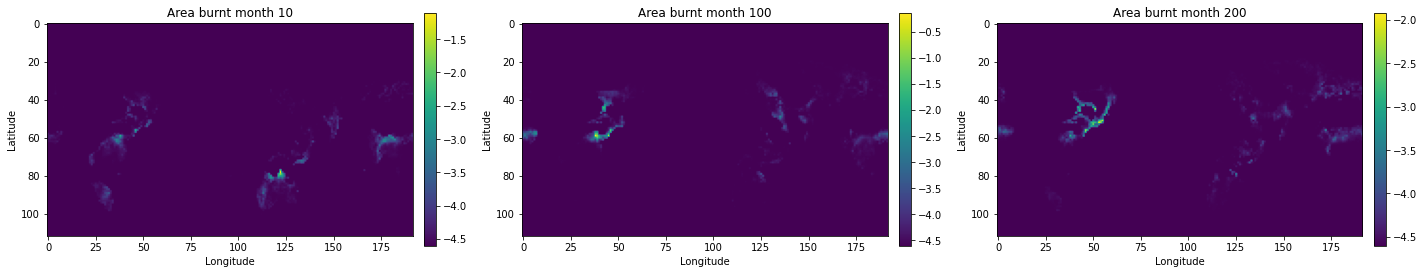

______________ Vegetation _____________


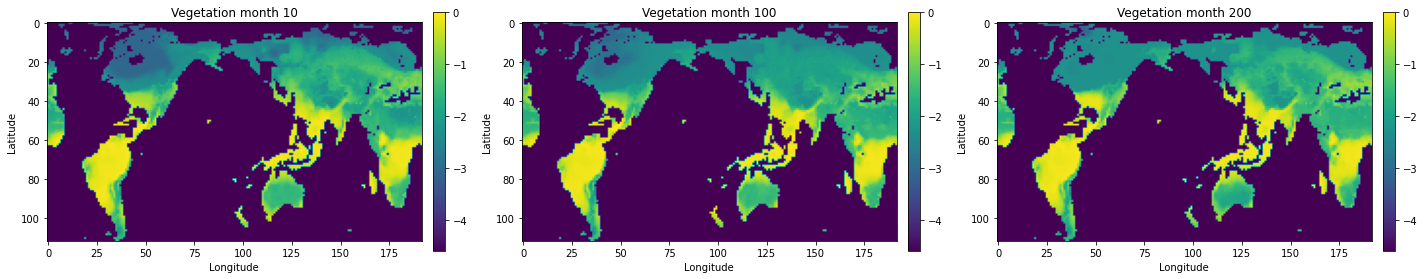

______________ Temperature _____________


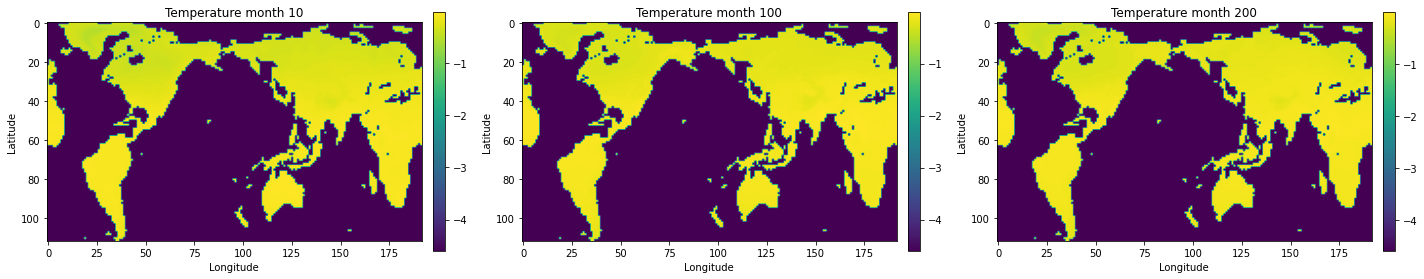

______________ Moisture _____________


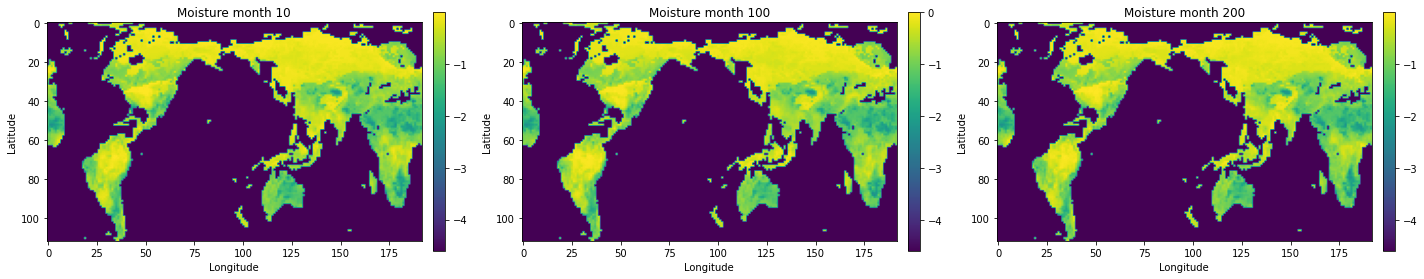

In [ ]:
print("______________ Area brunt _____________")
plot_data_img(nr = 1, nc=3, data=area_burnt_p1, true_data=area_burnt_p1, ts = [10, 100, 200], title='Area burnt month')

print("______________ Vegetation _____________")
plot_data_img(nr = 1, nc=3, data=veg_data_p1, true_data=veg_data_p1, ts = [10, 100, 200], title='Vegetation month')

print("______________ Temperature _____________")
plot_data_img(nr = 1, nc=3, data=T_data_p1, true_data=T_data_p1, ts = [10, 100, 200], title='Temperature month')

print("______________ Moisture _____________")
plot_data_img(nr = 1, nc=3, data=moist_data_p1, true_data=moist_data_p1, ts = [10, 100, 200], title='Moisture month')

### Import the compressors

In [ ]:
# Load compressor
area_compressor = load_model('/content/drive/MyDrive/Wildfires_IRP/compressors/CAE_areaburnt')
moist_compressor = load_model('/content/drive/MyDrive/Wildfires_IRP/compressors/CAE_moist')
T_compressor = load_model('/content/drive/MyDrive/Wildfires_IRP/compressors/CAE_temp')
veg_compressor = load_model('/content/drive/MyDrive/Wildfires_IRP/compressors/CAE_veg')

In [ ]:
area_encoder = area_compressor.get_layer(index=0)
moist_encoder = moist_compressor.get_layer(index=0)
temp_encoder = T_compressor.get_layer(index=0)
veg_encoder = veg_compressor.get_layer(index=0)

area_decoder = area_compressor.get_layer(index=1)
moist_decoder = moist_compressor.get_layer(index=1)
temp_decoder = T_compressor.get_layer(index=1)
veg_decoder = veg_compressor.get_layer(index=1)

### Compress the data

In [ ]:
area_training_comp_p1 = area_encoder.predict(area_burnt_p1)
area_training_comp_p2 = area_encoder.predict(area_burnt_p2)
area_training_comp_p3 = area_encoder.predict(area_burnt_p3)
print("Shape of P1 area training set after compression by the CAE: ", area_training_comp_p1.shape)
print("Shape of P2 area training set after compression by the CAE: ", area_training_comp_p2.shape)
print("Shape of P3 area training set after compression by the CAE: ", area_training_comp_p3.shape)

moist_training_comp_p1 = moist_encoder.predict(moist_data_p1)
print("Shape of P1 moisture soil training set after compression by the CAE: ", moist_training_comp_p1.shape)
moist_training_comp_p2 = moist_encoder.predict(moist_data_p2)
print("Shape of P2 moisture soil training set after compression by the CAE: ", moist_training_comp_p2.shape)
moist_training_comp_p3 = moist_encoder.predict(moist_data_p3)
print("Shape of P3 moisture soil training set after compression by the CAE: ", moist_training_comp_p3.shape)

temp_training_comp_p1 = temp_encoder.predict(T_data_p1)
print("Shape of P1 Temperature training set after compression by the CAE: ", temp_training_comp_p1.shape)
temp_training_comp_p2 = temp_encoder.predict(T_data_p2)
print("Shape of P2 Temperature training set after compression by the CAE: ", temp_training_comp_p2.shape)
temp_training_comp_p3 = temp_encoder.predict(T_data_p3)
print("Shape of P3 Temperature training set after compression by the CAE: ", temp_training_comp_p3.shape)

veg_training_comp_p1 = veg_encoder.predict(veg_data_p1)
print("Shape of P1 vegetation training set after compression by the CAE: ", veg_training_comp_p1.shape)
veg_training_comp_p2 = veg_encoder.predict(veg_data_p2)
print("Shape of P2 vegetation training set after compression by the CAE: ", veg_training_comp_p2.shape)
veg_training_comp_p3 = veg_encoder.predict(veg_data_p3)
print("Shape of P3 vegetation training set after compression by the CAE: ", veg_training_comp_p3.shape)

Shape of P1 area training set after compression by the CAE:  (360, 15)
Shape of P2 area training set after compression by the CAE:  (360, 15)
Shape of P3 area training set after compression by the CAE:  (360, 15)
Shape of P1 moisture soil training set after compression by the CAE:  (360, 15)
Shape of P2 moisture soil training set after compression by the CAE:  (360, 15)
Shape of P3 moisture soil training set after compression by the CAE:  (360, 15)
Shape of P1 Temperature training set after compression by the CAE:  (360, 15)
Shape of P2 Temperature training set after compression by the CAE:  (360, 15)
Shape of P3 Temperature training set after compression by the CAE:  (360, 15)
Shape of P1 vegetation training set after compression by the CAE:  (360, 15)
Shape of P2 vegetation training set after compression by the CAE:  (360, 15)
Shape of P3 vegetation training set after compression by the CAE:  (360, 15)


### Build the LSTM model - Many to Many (3 to 3)

In [ ]:
X_area_training_comp3to3_p1, Y_area_training_comp3to3_p1 = Select_previous_future_months(3, 3, area_training_comp_p1)
X_area_training_comp3to3_p2, Y_area_training_comp3to3_p2 = Select_previous_future_months(3, 3, area_training_comp_p2)
X_area_training_comp3to3_p3, Y_area_training_comp3to3_p3 = Select_previous_future_months(3, 3, area_training_comp_p3)

X_moist_training_comp3to3_p1, Y_moist_training_comp3to3_p1 = Select_previous_future_months(3, 3, moist_training_comp_p1)
X_moist_training_comp3to3_p2, Y_moist_training_comp3to3_p2 = Select_previous_future_months(3, 3, moist_training_comp_p2)
X_moist_training_comp3to3_p3, Y_moist_training_comp3to3_p3 = Select_previous_future_months(3, 3, moist_training_comp_p3)

X_temp_training_comp3to3_p1, Y_temp_training_comp3to3_p1 = Select_previous_future_months(3, 3, temp_training_comp_p1)
X_temp_training_comp3to3_p2, Y_temp_training_comp3to3_p2 = Select_previous_future_months(3, 3, temp_training_comp_p2)
X_temp_training_comp3to3_p3, Y_temp_training_comp3to3_p3 = Select_previous_future_months(3, 3, temp_training_comp_p3)

X_veg_training_comp3to3_p1, Y_veg_training_comp3to3_p1 = Select_previous_future_months(3, 3, veg_training_comp_p1)
X_veg_training_comp3to3_p2, Y_veg_training_comp3to3_p2 = Select_previous_future_months(3, 3, veg_training_comp_p2)
X_veg_training_comp3to3_p3, Y_veg_training_comp3to3_p3 = Select_previous_future_months(3, 3, veg_training_comp_p3)

In [ ]:
X_area_training_comp = np.concatenate([X_area_training_comp3to3_p1, X_area_training_comp3to3_p2, X_area_training_comp3to3_p3], axis=0)
Y_area_training_comp = np.concatenate([Y_area_training_comp3to3_p1, Y_area_training_comp3to3_p2, Y_area_training_comp3to3_p3], axis=0)

X_moist_training_comp = np.concatenate([X_moist_training_comp3to3_p1, X_moist_training_comp3to3_p2, X_moist_training_comp3to3_p3], axis=0)
Y_moist_training_comp = np.concatenate([Y_moist_training_comp3to3_p1, Y_moist_training_comp3to3_p2, Y_moist_training_comp3to3_p3], axis=0)

X_temp_training_comp = np.concatenate([X_temp_training_comp3to3_p1, X_temp_training_comp3to3_p2, X_temp_training_comp3to3_p3], axis=0)
Y_temp_training_comp = np.concatenate([Y_temp_training_comp3to3_p1, Y_temp_training_comp3to3_p2, Y_temp_training_comp3to3_p3], axis=0)

X_veg_training_comp = np.concatenate([X_veg_training_comp3to3_p1, X_veg_training_comp3to3_p2, X_veg_training_comp3to3_p3], axis=0)
Y_veg_training_comp = np.concatenate([Y_veg_training_comp3to3_p1, Y_veg_training_comp3to3_p2, Y_veg_training_comp3to3_p3], axis=0)

In [ ]:
Xdata_3m = np.concatenate((X_area_training_comp, X_moist_training_comp, X_temp_training_comp, X_veg_training_comp), axis=2)
Ydata_3m = np.concatenate((Y_area_training_comp, Y_moist_training_comp, Y_temp_training_comp, Y_veg_training_comp), axis=2)

In [ ]:
print("Shape of X: ", Xdata_3m.shape)
print("Shape of Y : ", Ydata_3m.shape)

Shape of X:  (1065, 3, 60)
Shape of Y :  (1065, 3, 60)


In [ ]:
# 1D
n_steps = 3
n_features = 60

model = Sequential()

# encoder layer
model.add(LSTM(512, activation='relu', input_shape=(n_steps, n_features), return_sequences=True))
model.add(LeakyReLU(0.1))
model.add(Dropout(0.2))

model.add(LSTM(256, activation='relu'))
model.add(LeakyReLU(0.1))
model.add(Dropout(0.2))

# repeat vector
model.add(RepeatVector(3))

# decoder layer
model.add(LSTM(150, activation='relu', return_sequences=True))
model.add(LeakyReLU(0.1))
model.add(Dropout(0.2))

model.add(TimeDistributed(Dense(n_features)))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 3, 512)            1173504   
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 3, 512)            0         
                                                                 
 dropout_3 (Dropout)         (None, 3, 512)            0         
                                                                 
 lstm_4 (LSTM)               (None, 256)               787456    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 256)               0         
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 repeat_vector_1 (RepeatVect  (None, 3, 256)          

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                               min_delta=0.0,
                                               patience=50,
                                               verbose=2,
                                               restore_best_weights=True)

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=50)
model.compile(optimizer='adam', loss='mse', metrics=['mse'])

In [ ]:
train, val, ytrain, yval = train_test_split(Xdata_3m, Ydata_3m, test_size=0.15, random_state=123)

In [ ]:
start = time.time()
history = model.fit(train, ytrain, validation_split=0.2, shuffle=True,
                    epochs=1000,
                    verbose=1,
                    callbacks=[early_stopping, reduce_lr])
end = time.time()

Epoch 1/1000
23/23 [==============================] - 4s 43ms/step - loss: 0.3147 - mse: 0.3147 - val_loss: 0.2965 - val_mse: 0.2965 - lr: 0.0010
Epoch 2/1000
23/23 [==============================] - 1s 28ms/step - loss: 0.2425 - mse: 0.2425 - val_loss: 0.2457 - val_mse: 0.2457 - lr: 0.0010
Epoch 3/1000
23/23 [==============================] - 0s 21ms/step - loss: 0.2151 - mse: 0.2151 - val_loss: 0.2286 - val_mse: 0.2286 - lr: 0.0010
Epoch 4/1000
23/23 [==============================] - 0s 20ms/step - loss: 0.2030 - mse: 0.2030 - val_loss: 0.2192 - val_mse: 0.2192 - lr: 0.0010
Epoch 5/1000
23/23 [==============================] - 0s 20ms/step - loss: 0.1937 - mse: 0.1937 - val_loss: 0.2118 - val_mse: 0.2118 - lr: 0.0010
Epoch 6/1000
23/23 [==============================] - 0s 20ms/step - loss: 0.1861 - mse: 0.1861 - val_loss: 0.1993 - val_mse: 0.1993 - lr: 0.0010
Epoch 7/1000
23/23 [==============================] - 0s 20ms/step - loss: 0.1772 - mse: 0.1772 - val_loss: 0.1872 - val_mse

______________ Loss plot of CAE + LSTM with 6 months as inputs__________________



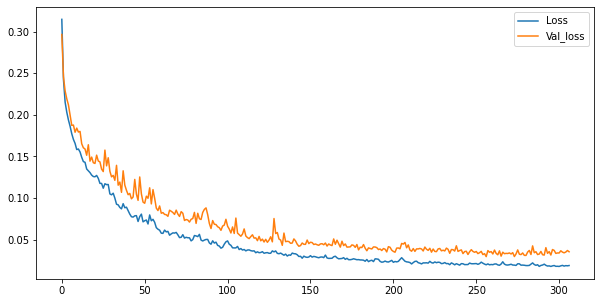

In [ ]:
print("______________ Loss plot of CAE + LSTM with 6 months as inputs__________________\n")
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Loss', 'Val_loss']);

In [ ]:
print("Best score : ", model.evaluate(train, ytrain, verbose=0))

Best score :  [0.011312988586723804, 0.011312989518046379]


In [ ]:
predictions = model.predict(val)
print("Shape of the predictions set: ", predictions.shape)
print("Shape of the original test set: ", yval.shape)

Shape of the predictions set:  (160, 3, 60)
Shape of the original test set:  (160, 3, 60)


In [ ]:
pred_train = model.predict(train)
relative_mse_train_nw = [np.linalg.norm(elem2 - elem) / (112*192) for elem, elem2 in zip(pred_train, ytrain)]
relative_mse_train_ow = np.linalg.norm(pred_train - ytrain) / (112*192)
mse_train = mean_squared_error(pred_train.ravel(), ytrain.ravel())
print("___________Training set predictions______________")
print('mse for train dataset: ', np.mean(relative_mse_train_nw))
print('\n Time to train AE: ', round(end-start, 2), 's')

relative_mse_test_nw = [np.linalg.norm(elem2 - elem) / (112*192) for elem, elem2 in zip(predictions, yval)]
relative_mse_test_ow = np.linalg.norm(predictions - yval) / (112*192)
print("\n___________Testing set predictions______________")
print('mse for test dataset: ', np.mean(relative_mse_test_nw))
mse_test = mean_squared_error(predictions.ravel(), yval.ravel())

___________Training set predictions______________
mse for train dataset:  3.948011027760861e-05

 Time to train AE:  336.88 s

___________Testing set predictions______________
mse for test dataset:  6.223246561896191e-05


In [ ]:
model.save('/content/drive/MyDrive/Wildfires_IRP/model/Multi_CAE_LSTM/multi_CAE_LSTM_3to3.h5')
#model = load_model('/content/drive/MyDrive/Wildfires_IRP/model/Multi_CAE_LSTM/multi_CAE_LSTM_3to3.h5')

In [ ]:
results_multi_CAE_LSTM_3to3 = {'Time for training (s)':  round(end-start, 2),
           'relative mse_test new way':  np.mean(relative_mse_test_nw), 
           'relative mse_train new way': np.mean(relative_mse_train_nw),
           'relative mse_test old way':  relative_mse_test_ow, 
           'relative mse_train old way': relative_mse_train_ow,
           'mse test' : mse_test,
           'mse_train': mse_train
          }

In [ ]:
results_multi_CAE_LSTM_3to3

{'Time for training (s)': 145.42,
 'mse test': 0.0291037,
 'mse_train': 0.006927698,
 'relative mse_test new way': 3.332729083574881e-05,
 'relative mse_test old way': 0.0007699814935525259,
 'relative mse_train new way': 2.0201306342889117e-05,
 'relative mse_train old way': 0.0008929201534816197}

### Build the LSTM model - Many to Many (6 to 6)

In [ ]:
X_area_training_comp6to6_p1, Y_area_training_comp6to6_p1 = Select_previous_future_months(6, 6, area_training_comp_p1)
X_area_training_comp6to6_p2, Y_area_training_comp6to6_p2 = Select_previous_future_months(6, 6, area_training_comp_p2)
X_area_training_comp6to6_p3, Y_area_training_comp6to6_p3 = Select_previous_future_months(6, 6, area_training_comp_p3)

X_moist_training_comp6to6_p1, Y_moist_training_comp6to6_p1 = Select_previous_future_months(6, 6, moist_training_comp_p1)
X_moist_training_comp6to6_p2, Y_moist_training_comp6to6_p2 = Select_previous_future_months(6, 6, moist_training_comp_p2)
X_moist_training_comp6to6_p3, Y_moist_training_comp6to6_p3 = Select_previous_future_months(6, 6, moist_training_comp_p3)

X_temp_training_comp6to6_p1, Y_temp_training_comp6to6_p1 = Select_previous_future_months(6, 6, temp_training_comp_p1)
X_temp_training_comp6to6_p2, Y_temp_training_comp6to6_p2 = Select_previous_future_months(6, 6, temp_training_comp_p2)
X_temp_training_comp6to6_p3, Y_temp_training_comp6to6_p3 = Select_previous_future_months(6, 6, temp_training_comp_p3)

X_veg_training_comp6to6_p1, Y_veg_training_comp6to6_p1 = Select_previous_future_months(6, 6, veg_training_comp_p1)
X_veg_training_comp6to6_p2, Y_veg_training_comp6to6_p2 = Select_previous_future_months(6, 6, veg_training_comp_p2)
X_veg_training_comp6to6_p3, Y_veg_training_comp6to6_p3 = Select_previous_future_months(6, 6, veg_training_comp_p3)

In [ ]:
X_area_training_comp = np.concatenate([X_area_training_comp6to6_p1, X_area_training_comp6to6_p2, X_area_training_comp6to6_p3], axis=0)
Y_area_training_comp = np.concatenate([Y_area_training_comp6to6_p1, Y_area_training_comp6to6_p2, Y_area_training_comp6to6_p3], axis=0)

X_moist_training_comp = np.concatenate([X_moist_training_comp6to6_p1, X_moist_training_comp6to6_p2, X_moist_training_comp6to6_p3], axis=0)
Y_moist_training_comp = np.concatenate([Y_moist_training_comp6to6_p1, Y_moist_training_comp6to6_p2, Y_moist_training_comp6to6_p3], axis=0)

X_temp_training_comp = np.concatenate([X_temp_training_comp6to6_p1, X_temp_training_comp6to6_p2, X_temp_training_comp6to6_p3], axis=0)
Y_temp_training_comp = np.concatenate([Y_temp_training_comp6to6_p1, Y_temp_training_comp6to6_p2, Y_temp_training_comp6to6_p3], axis=0)

X_veg_training_comp = np.concatenate([X_veg_training_comp6to6_p1, X_veg_training_comp6to6_p2, X_veg_training_comp6to6_p3], axis=0)
Y_veg_training_comp = np.concatenate([Y_veg_training_comp6to6_p1, Y_veg_training_comp6to6_p2, Y_veg_training_comp6to6_p3], axis=0)

In [ ]:
Xdata_6m = np.concatenate((X_area_training_comp, X_moist_training_comp, X_temp_training_comp, X_veg_training_comp), axis=2)
Ydata_6m = np.concatenate((Y_area_training_comp, Y_moist_training_comp, Y_temp_training_comp, Y_veg_training_comp), axis=2)

In [ ]:
print("Shape of X: ", Xdata_6m.shape)
print("Shape of Y : ", Ydata_6m.shape)

Shape of X:  (1047, 6, 60)
Shape of Y :  (1047, 6, 60)


In [ ]:
# 1D
n_steps = 6
n_features = 60

model = Sequential()

# encoder layer
model.add(LSTM(512, activation='relu', input_shape=(n_steps, n_features), return_sequences=True))
model.add(LeakyReLU(0.1))
model.add(Dropout(0.2))

model.add(LSTM(256, activation='relu'))
model.add(LeakyReLU(0.1))
model.add(Dropout(0.2))

# repeat vector
model.add(RepeatVector(6))

# decoder layer
model.add(LSTM(150, activation='relu', return_sequences=True))
model.add(LeakyReLU(0.1))
model.add(Dropout(0.2))

model.add(TimeDistributed(Dense(n_features)))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 6, 512)            1173504   
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 6, 512)            0         
                                                                 
 dropout_6 (Dropout)         (None, 6, 512)            0         
                                                                 
 lstm_7 (LSTM)               (None, 256)               787456    
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 256)               0         
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 repeat_vector_2 (RepeatVect  (None, 6, 256)          

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                               min_delta=0.0,
                                               patience=50,
                                               verbose=2,
                                               restore_best_weights=True)

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=50)
model.compile(optimizer='adam', loss='mse', metrics=['mse'])

In [ ]:
train, val, ytrain, yval = train_test_split(Xdata_6m, Ydata_6m, test_size=0.15, random_state=123)

In [ ]:
start = time.time()
history = model.fit(train, ytrain, validation_split=0.2, shuffle=True,
                    epochs=1000,
                    verbose=1,
                    callbacks=[early_stopping, reduce_lr])
end = time.time()

Epoch 1/1000
23/23 [==============================] - 4s 52ms/step - loss: 0.3182 - mse: 0.3182 - val_loss: 0.2884 - val_mse: 0.2884 - lr: 0.0010
Epoch 2/1000
23/23 [==============================] - 1s 31ms/step - loss: 0.2621 - mse: 0.2621 - val_loss: 0.2542 - val_mse: 0.2542 - lr: 0.0010
Epoch 3/1000
23/23 [==============================] - 1s 32ms/step - loss: 0.2392 - mse: 0.2392 - val_loss: 0.2374 - val_mse: 0.2374 - lr: 0.0010
Epoch 4/1000
23/23 [==============================] - 1s 33ms/step - loss: 0.2221 - mse: 0.2221 - val_loss: 0.2224 - val_mse: 0.2224 - lr: 0.0010
Epoch 5/1000
23/23 [==============================] - 1s 34ms/step - loss: 0.2083 - mse: 0.2083 - val_loss: 0.2114 - val_mse: 0.2114 - lr: 0.0010
Epoch 6/1000
23/23 [==============================] - 1s 32ms/step - loss: 0.1998 - mse: 0.1998 - val_loss: 0.2053 - val_mse: 0.2053 - lr: 0.0010
Epoch 7/1000
23/23 [==============================] - 1s 31ms/step - loss: 0.1903 - mse: 0.1903 - val_loss: 0.2019 - val_mse

______________ Loss plot of CAE + LSTM with 6 months as inputs__________________



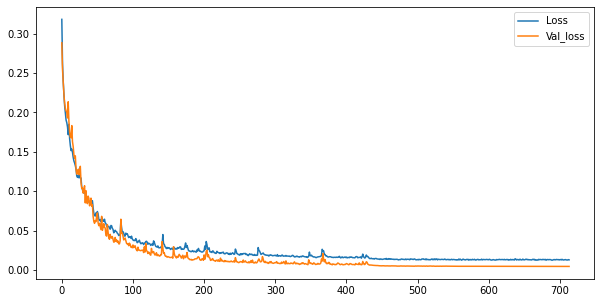

In [ ]:
print("______________ Loss plot of CAE + LSTM with 6 months as inputs__________________\n")
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Loss', 'Val_loss']);

In [ ]:
print("Best score : ", model.evaluate(train, ytrain, verbose=0))

Best score :  [0.002939659869298339, 0.002939659869298339]


In [ ]:
predictions = model.predict(val)
print("Shape of the predictions set: ", predictions.shape)
print("Shape of the original test set: ", yval.shape)

Shape of the predictions set:  (158, 6, 60)
Shape of the original test set:  (158, 6, 60)


In [ ]:
pred_train = model.predict(train)
relative_mse_train_nw = [np.linalg.norm(elem2 - elem) / (112*192) for elem, elem2 in zip(pred_train, ytrain)]
relative_mse_train_ow = np.linalg.norm(pred_train - ytrain) / (112*192)
mse_train = mean_squared_error(pred_train.ravel(), ytrain.ravel())
print("___________Training set predictions______________")
print('mse for train dataset: ', np.mean(relative_mse_train_nw))
print('\n Time to train AE: ', round(end-start, 2), 's')

relative_mse_test_nw = [np.linalg.norm(elem2 - elem) / (112*192) for elem, elem2 in zip(predictions, yval)]
relative_mse_test_ow = np.linalg.norm(predictions - yval) / (112*192)
print("\n___________Testing set predictions______________")
print('mse for test dataset: ', np.mean(relative_mse_test_nw))
mse_test = mean_squared_error(predictions.ravel(), yval.ravel())

___________Training set predictions______________
mse for train dataset:  4.5546231634310854e-05

 Time to train AE:  530.04 s

___________Testing set predictions______________
mse for test dataset:  5.8652179504729555e-05


In [ ]:
model.save('/content/drive/MyDrive/Wildfires_IRP/model/Multi_CAE_LSTM/multi_CAE_LSTM_6to6.h5')
# model = load_model('/content/drive/MyDrive/Wildfires_IRP/model/Multi_CAE_LSTM/multi_CAE_LSTM_6to6.h5')

In [ ]:
results_multi_CAE_LSTM_6to6 = {'Time for training (s)':  round(end-start, 2),
           'relative mse_test new way':  np.mean(relative_mse_test_nw), 
           'relative mse_train new way': np.mean(relative_mse_train_nw),
           'relative mse_test old way':  relative_mse_test_ow, 
           'relative mse_train old way': relative_mse_train_ow,
           'mse test' : mse_test,
           'mse_train': mse_train
          }

In [ ]:
results_multi_CAE_LSTM_6to6

{'Time for training (s)': 530.04,
 'mse test': 0.0057935882,
 'mse_train': 0.0029396596,
 'relative mse_test new way': 5.8652179504729555e-05,
 'relative mse_test old way': 0.000844178543913932,
 'relative mse_train new way': 4.5546231634310854e-05,
 'relative mse_train old way': 0.0014263660247836793}

### Build the LSTM model - Many to Many (12 to 12)

In [ ]:
X_area_training_comp12to12_p1, Y_area_training_comp12to12_p1 = Select_previous_future_months(12, 12, area_training_comp_p1)
X_area_training_comp12to12_p2, Y_area_training_comp12to12_p2 = Select_previous_future_months(12, 12, area_training_comp_p2)
X_area_training_comp12to12_p3, Y_area_training_comp12to12_p3 = Select_previous_future_months(12, 12, area_training_comp_p3)

X_moist_training_comp12to12_p1, Y_moist_training_comp12to12_p1 = Select_previous_future_months(12, 12, moist_training_comp_p1)
X_moist_training_comp12to12_p2, Y_moist_training_comp12to12_p2 = Select_previous_future_months(12, 12, moist_training_comp_p2)
X_moist_training_comp12to12_p3, Y_moist_training_comp12to12_p3 = Select_previous_future_months(12, 12, moist_training_comp_p3)

X_temp_training_comp12to12_p1, Y_temp_training_comp12to12_p1 = Select_previous_future_months(12, 12, temp_training_comp_p1)
X_temp_training_comp12to12_p2, Y_temp_training_comp12to12_p2 = Select_previous_future_months(12, 12, temp_training_comp_p2)
X_temp_training_comp12to12_p3, Y_temp_training_comp12to12_p3 = Select_previous_future_months(12, 12, temp_training_comp_p3)

X_veg_training_comp12to12_p1, Y_veg_training_comp12to12_p1 = Select_previous_future_months(12, 12, veg_training_comp_p1)
X_veg_training_comp12to12_p2, Y_veg_training_comp12to12_p2 = Select_previous_future_months(12, 12, veg_training_comp_p2)
X_veg_training_comp12to12_p3, Y_veg_training_comp12to12_p3 = Select_previous_future_months(12, 12, veg_training_comp_p3)

In [ ]:
X_area_training_comp = np.concatenate([X_area_training_comp12to12_p1, X_area_training_comp12to12_p2, X_area_training_comp12to12_p3], axis=0)
Y_area_training_comp = np.concatenate([Y_area_training_comp12to12_p1, Y_area_training_comp12to12_p2, Y_area_training_comp12to12_p3], axis=0)

X_moist_training_comp = np.concatenate([X_moist_training_comp12to12_p1, X_moist_training_comp12to12_p2, X_moist_training_comp12to12_p3], axis=0)
Y_moist_training_comp = np.concatenate([Y_moist_training_comp12to12_p1, Y_moist_training_comp12to12_p2, Y_moist_training_comp12to12_p3], axis=0)

X_temp_training_comp = np.concatenate([X_temp_training_comp12to12_p1, X_temp_training_comp12to12_p2, X_temp_training_comp12to12_p3], axis=0)
Y_temp_training_comp = np.concatenate([Y_temp_training_comp12to12_p1, Y_temp_training_comp12to12_p2, Y_temp_training_comp12to12_p3], axis=0)

X_veg_training_comp = np.concatenate([X_veg_training_comp12to12_p1, X_veg_training_comp12to12_p2, X_veg_training_comp12to12_p3], axis=0)
Y_veg_training_comp = np.concatenate([Y_veg_training_comp12to12_p1, Y_veg_training_comp12to12_p2, Y_veg_training_comp12to12_p3], axis=0)

In [ ]:
Xdata_12m = np.concatenate((X_area_training_comp, X_moist_training_comp, X_temp_training_comp, X_veg_training_comp), axis=2)
Ydata_12m = np.concatenate((Y_area_training_comp, Y_moist_training_comp, Y_temp_training_comp, Y_veg_training_comp), axis=2)

In [ ]:
print("Shape of X: ", Xdata_12m.shape)
print("Shape of Y : ", Ydata_12m.shape)

Shape of X:  (1011, 12, 60)
Shape of Y :  (1011, 12, 60)


In [ ]:
# 1D
n_steps = 12
n_features = 60

model = Sequential()

# encoder layer
model.add(LSTM(512, activation='relu', input_shape=(n_steps, n_features), return_sequences=True))
model.add(LeakyReLU(0.1))
model.add(Dropout(0.2))

model.add(LSTM(256, activation='relu'))
model.add(LeakyReLU(0.1))
model.add(Dropout(0.2))

# repeat vector
model.add(RepeatVector(12))

# decoder layer
model.add(LSTM(150, activation='relu', return_sequences=True))
model.add(LeakyReLU(0.1))
model.add(Dropout(0.2))

model.add(TimeDistributed(Dense(n_features)))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 12, 512)           1173504   
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 12, 512)           0         
                                                                 
 dropout_9 (Dropout)         (None, 12, 512)           0         
                                                                 
 lstm_10 (LSTM)              (None, 256)               787456    
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 256)               0         
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                                 
 repeat_vector_3 (RepeatVect  (None, 12, 256)         

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                               min_delta=0.0,
                                               patience=50,
                                               verbose=2,
                                               restore_best_weights=True)

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=20)
model.compile(optimizer='adam', loss='mse', metrics=['mse'])

In [ ]:
train, val, ytrain, yval = train_test_split(Xdata_12m, Ydata_12m, test_size=0.15, random_state=123)

In [ ]:
start = time.time()
history = model.fit(train, ytrain, validation_split=0.2, shuffle=True,
                    epochs=1000,
                    verbose=1,
                    callbacks=[early_stopping, reduce_lr])
end = time.time()

Epoch 1/1000
22/22 [==============================] - 5s 93ms/step - loss: 0.3161 - mse: 0.3161 - val_loss: 0.2692 - val_mse: 0.2692 - lr: 0.0010
Epoch 2/1000
22/22 [==============================] - 1s 57ms/step - loss: 0.2853 - mse: 0.2853 - val_loss: 0.2623 - val_mse: 0.2623 - lr: 0.0010
Epoch 3/1000
22/22 [==============================] - 1s 57ms/step - loss: 0.2786 - mse: 0.2786 - val_loss: 0.2589 - val_mse: 0.2589 - lr: 0.0010
Epoch 4/1000
22/22 [==============================] - 2s 76ms/step - loss: 0.2753 - mse: 0.2753 - val_loss: 0.2568 - val_mse: 0.2568 - lr: 0.0010
Epoch 5/1000
22/22 [==============================] - 1s 56ms/step - loss: 0.2726 - mse: 0.2726 - val_loss: 0.2544 - val_mse: 0.2544 - lr: 0.0010
Epoch 6/1000
22/22 [==============================] - 1s 57ms/step - loss: 0.2692 - mse: 0.2692 - val_loss: 0.2516 - val_mse: 0.2516 - lr: 0.0010
Epoch 7/1000
22/22 [==============================] - 1s 57ms/step - loss: 0.2665 - mse: 0.2665 - val_loss: 0.2479 - val_mse

______________ Loss plot of multi CAE + LSTM with 12 months as inputs__________________



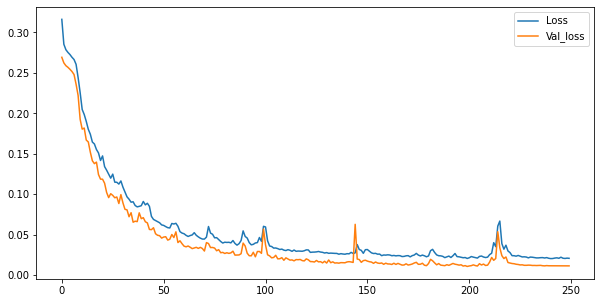

In [ ]:
print("______________ Loss plot of multi CAE + LSTM with 12 months as inputs__________________\n")
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Loss', 'Val_loss']);

In [ ]:
print("Best score : ", model.evaluate(train, ytrain, verbose=0))

Best score :  [0.007730419747531414, 0.007730420213192701]


In [ ]:
predictions = model.predict(val)
print("Shape of the predictions set: ", predictions.shape)
print("Shape of the original test set: ", yval.shape)

Shape of the predictions set:  (152, 12, 60)
Shape of the original test set:  (152, 12, 60)


In [ ]:
pred_train = model.predict(train)

relative_mse_train_nw = [np.linalg.norm(elem2 - elem) / (112*192) for elem, elem2 in zip(pred_train, ytrain)]
relative_mse_train_ow = np.linalg.norm(pred_train - ytrain) / (112*192)
mse_train = mean_squared_error(pred_train.ravel(), ytrain.ravel())
print("___________Training set predictions______________")
print('mse for train dataset: ', np.mean(relative_mse_train_nw))
print('\n Time to train AE: ', round(end - start, 2), 's')

relative_mse_test_nw = [np.linalg.norm(elem2 - elem) / (112*192) for elem, elem2 in zip(predictions, yval)]
relative_mse_test_ow = np.linalg.norm(predictions - yval) / (112*192)
mse_test = mean_squared_error(predictions.ravel(), yval.ravel())
print("\n___________Testing set predictions______________")
print('mse for test dataset: ', np.mean(relative_mse_test_nw))

___________Training set predictions______________
mse for train dataset:  0.00010478259043347692

 Time to train AE:  318.9 s

___________Testing set predictions______________
mse for test dataset:  0.00011658367125654738


In [ ]:
model.save('/content/drive/MyDrive/Wildfires_IRP/model/Multi_CAE_LSTM/multi_CAE_LSTM_12to12.h5')
#model = load_model('/content/drive/MyDrive/Wildfires_IRP/model/Multi_CAE_LSTM/multi_CAE_LSTM_12to12.h5')

In [ ]:
results_multi_CAE_LSTM_12to12 = {'Time for training (s)':  round(end -start, 2),
           'relative mse_test new way':  np.mean(relative_mse_test_nw), 
           'relative mse_train new way': np.mean(relative_mse_train_nw),
           'relative mse_test old way':  relative_mse_test_ow, 
           'relative mse_train old way': relative_mse_train_ow,
           'mse test' : mse_test,
           'mse_train': mse_train
          }

In [ ]:
results_multi_CAE_LSTM_12to12

{'Time for training (s)': 318.9,
 'mse test': 0.01040911,
 'mse_train': 0.007730419,
 'relative mse_test new way': 0.00011658367125654738,
 'relative mse_test old way': 0.0015695511939979735,
 'relative mse_train new way': 0.00010478259043347692,
 'relative mse_train old way': 0.0032154665816397894}

### Build the LSTM model - Many to One (6 to 1)

In [ ]:
X_area_training_comp6to1_p1, Y_area_training_comp6to1_p1 = Select_previous_future_months(6, 1, area_training_comp_p1)
X_area_training_comp6to1_p2, Y_area_training_comp6to1_p2 = Select_previous_future_months(6, 1, area_training_comp_p2)
X_area_training_comp6to1_p3, Y_area_training_comp6to1_p3 = Select_previous_future_months(6, 1, area_training_comp_p3)

X_moist_training_comp6to1_p1, Y_moist_training_comp6to1_p1 = Select_previous_future_months(6, 1, moist_training_comp_p1)
X_moist_training_comp6to1_p2, Y_moist_training_comp6to1_p2 = Select_previous_future_months(6, 1, moist_training_comp_p2)
X_moist_training_comp6to1_p3, Y_moist_training_comp6to1_p3 = Select_previous_future_months(6, 1, moist_training_comp_p3)

X_temp_training_comp6to1_p1, Y_temp_training_comp6to1_p1 = Select_previous_future_months(6, 1, temp_training_comp_p1)
X_temp_training_comp6to1_p2, Y_temp_training_comp6to1_p2 = Select_previous_future_months(6, 1, temp_training_comp_p2)
X_temp_training_comp6to1_p3, Y_temp_training_comp6to1_p3 = Select_previous_future_months(6, 1, temp_training_comp_p3)

X_veg_training_comp6to1_p1, Y_veg_training_comp6to1_p1 = Select_previous_future_months(6, 1, veg_training_comp_p1)
X_veg_training_comp6to1_p2, Y_veg_training_comp6to1_p2 = Select_previous_future_months(6, 1, veg_training_comp_p2)
X_veg_training_comp6to1_p3, Y_veg_training_comp6to1_p3 = Select_previous_future_months(6, 1, veg_training_comp_p3)

In [ ]:
X_area_training_comp = np.concatenate([X_area_training_comp6to1_p1, X_area_training_comp6to1_p2, X_area_training_comp6to1_p3], axis=0)
Y_area_training_comp = np.concatenate([Y_area_training_comp6to1_p1, Y_area_training_comp6to1_p2, Y_area_training_comp6to1_p3], axis=0)

X_moist_training_comp = np.concatenate([X_moist_training_comp6to1_p1, X_moist_training_comp6to1_p2, X_moist_training_comp6to1_p3], axis=0)
Y_moist_training_comp = np.concatenate([Y_moist_training_comp6to1_p1, Y_moist_training_comp6to1_p2, Y_moist_training_comp6to1_p3], axis=0)

X_temp_training_comp = np.concatenate([X_temp_training_comp6to1_p1, X_temp_training_comp6to1_p2, X_temp_training_comp6to1_p3], axis=0)
Y_temp_training_comp = np.concatenate([Y_temp_training_comp6to1_p1, Y_temp_training_comp6to1_p2, Y_temp_training_comp6to1_p3], axis=0)

X_veg_training_comp = np.concatenate([X_veg_training_comp6to1_p1, X_veg_training_comp6to1_p2, X_veg_training_comp6to1_p3], axis=0)
Y_veg_training_comp = np.concatenate([Y_veg_training_comp6to1_p1, Y_veg_training_comp6to1_p2, Y_veg_training_comp6to1_p3], axis=0)

In [ ]:
Xdata_6to1 = np.concatenate((X_area_training_comp, X_moist_training_comp, X_temp_training_comp, X_veg_training_comp), axis=2)
Ydata_6to1 = np.concatenate((Y_area_training_comp, Y_moist_training_comp, Y_temp_training_comp, Y_veg_training_comp), axis=2)

In [ ]:
print("Shape of X: ", Xdata_6to1.shape)
print("Shape of Y : ", Ydata_6to1.shape)

Shape of X:  (1062, 6, 60)
Shape of Y :  (1062, 1, 60)


In [ ]:
# 1D
n_steps = 6
n_features = 60

model = Sequential()

# encoder layer
model.add(LSTM(450, activation='relu', input_shape=(n_steps, n_features))) #, return_sequences=True
model.add(LeakyReLU(0.1))
model.add(Dropout(0.2))

# repeat vector
model.add(RepeatVector(1))

# decoder layer
model.add(LSTM(150, activation='relu', return_sequences=True))
model.add(LeakyReLU(0.1))
model.add(Dropout(0.2))

model.add(TimeDistributed(Dense(n_features)))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 450)               919800    
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 450)               0         
                                                                 
 dropout_12 (Dropout)        (None, 450)               0         
                                                                 
 repeat_vector_4 (RepeatVect  (None, 1, 450)           0         
 or)                                                             
                                                                 
 lstm_13 (LSTM)              (None, 1, 150)            360600    
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 1, 150)            0         
                                                      

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                               min_delta=0.0,
                                               patience=50,
                                               verbose=2,
                                               restore_best_weights=True)

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=20)
model.compile(optimizer='adam', loss='mse', metrics=['mse'])

In [ ]:
train, val, ytrain, yval = train_test_split(Xdata_6to1, Ydata_6to1, test_size=0.15, random_state=123)

In [ ]:
start = time.time()
history = model.fit(train, ytrain, validation_split=0.15, shuffle=True,
                    epochs=1000,
                    verbose=1,
                    callbacks=[early_stopping, reduce_lr])
end = time.time()

Epoch 1/1000
24/24 [==============================] - 3s 29ms/step - loss: 0.2946 - mse: 0.2946 - val_loss: 0.1847 - val_mse: 0.1847 - lr: 0.0010
Epoch 2/1000
24/24 [==============================] - 0s 15ms/step - loss: 0.2203 - mse: 0.2203 - val_loss: 0.1633 - val_mse: 0.1633 - lr: 0.0010
Epoch 3/1000
24/24 [==============================] - 0s 15ms/step - loss: 0.2005 - mse: 0.2005 - val_loss: 0.1499 - val_mse: 0.1499 - lr: 0.0010
Epoch 4/1000
24/24 [==============================] - 0s 15ms/step - loss: 0.1781 - mse: 0.1781 - val_loss: 0.1448 - val_mse: 0.1448 - lr: 0.0010
Epoch 5/1000
24/24 [==============================] - 0s 15ms/step - loss: 0.1711 - mse: 0.1711 - val_loss: 0.1370 - val_mse: 0.1370 - lr: 0.0010
Epoch 6/1000
24/24 [==============================] - 0s 15ms/step - loss: 0.1633 - mse: 0.1633 - val_loss: 0.1453 - val_mse: 0.1453 - lr: 0.0010
Epoch 7/1000
24/24 [==============================] - 0s 16ms/step - loss: 0.1507 - mse: 0.1507 - val_loss: 0.1256 - val_mse

______________ Loss plot of multi CAE + LSTM with 6 months as inputs__________________



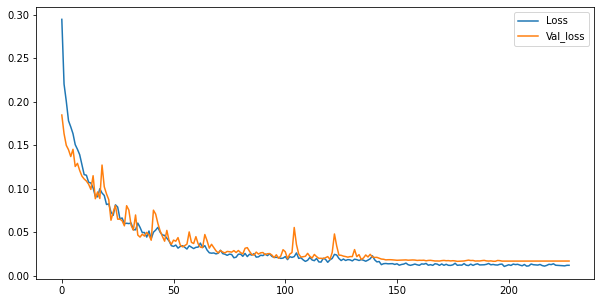

In [ ]:
print("______________ Loss plot of multi CAE + LSTM with 6 months as inputs__________________\n")
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Loss', 'Val_loss']);

In [ ]:
print("Best score : ", model.evaluate(train, ytrain, verbose=0))

Best score :  [0.0047628022730350494, 0.0047628022730350494]


In [ ]:
predictions = model.predict(val)
print("Shape of the predictions set: ", predictions.shape)
print("Shape of the original test set: ", yval.shape)

Shape of the predictions set:  (160, 1, 60)
Shape of the original test set:  (160, 1, 60)


In [ ]:
pred_train = model.predict(train)

relative_mse_train_nw = [np.linalg.norm(elem2 - elem) / (112*192) for elem, elem2 in zip(pred_train, ytrain)]
relative_mse_train_ow = np.linalg.norm(pred_train - ytrain) / (112*192)
mse_train = mean_squared_error(pred_train.ravel(), ytrain.ravel())
print("___________Training set predictions______________")
print('mse for train dataset: ', np.mean(relative_mse_train_nw))
print('\n Time to train AE: ', round(end- start, 2), 's')

relative_mse_test_nw = [np.linalg.norm(elem2 - elem) / (112*192) for elem, elem2 in zip(predictions, yval)]
relative_mse_test_ow = np.linalg.norm(predictions - yval) / (112*192)
mse_test = mean_squared_error(predictions.ravel(), yval.ravel())
print("\n___________Testing set predictions______________")
print('mse for test dataset: ', np.mean(relative_mse_test_nw))

___________Training set predictions______________
mse for train dataset:  1.9109372485761862e-05

 Time to train AE:  83.83 s

___________Testing set predictions______________
mse for test dataset:  2.9621200030219154e-05


In [ ]:
model.save('/content/drive/MyDrive/Wildfires_IRP/model/Multi_CAE_LSTM/multi_CAE_LSTM_6to1.h5')
#model = load_model('/content/drive/MyDrive/Wildfires_IRP/model/Multi_CAE_LSTM/multi_CAE_LSTM_6to1.h5')

In [ ]:
results_multi_CAE_LSTM_6to1 = {'Time for training (s)':  round(end - start, 2),
           'relative mse_test new way':  np.mean(relative_mse_test_nw), 
           'relative mse_train new way': np.mean(relative_mse_train_nw),
           'relative mse_test old way':  relative_mse_test_ow, 
           'relative mse_train old way': relative_mse_train_ow,
           'mse test' : mse_test,
           'mse_train': mse_train
          }

In [ ]:
results_multi_CAE_LSTM_6to1

{'Time for training (s)': 83.83,
 'mse test': 0.016014175,
 'mse_train': 0.0047628027,
 'relative mse_test new way': 2.9621200030219154e-05,
 'relative mse_test old way': 0.0005765920504927635,
 'relative mse_train new way': 1.9109372485761862e-05,
 'relative mse_train old way': 0.0007466050308375131}

### Build the LSTM model - Many to One (12 to 1)

In [ ]:
X_area_training_comp12to1_p1, Y_area_training_comp12to1_p1 = Select_previous_future_months(12, 1, area_training_comp_p1)
X_area_training_comp12to1_p2, Y_area_training_comp12to1_p2 = Select_previous_future_months(12, 1, area_training_comp_p2)
X_area_training_comp12to1_p3, Y_area_training_comp12to1_p3 = Select_previous_future_months(12, 1, area_training_comp_p3)

X_moist_training_comp12to1_p1, Y_moist_training_comp12to1_p1 = Select_previous_future_months(12, 1, moist_training_comp_p1)
X_moist_training_comp12to1_p2, Y_moist_training_comp12to1_p2 = Select_previous_future_months(12, 1, moist_training_comp_p2)
X_moist_training_comp12to1_p3, Y_moist_training_comp12to1_p3 = Select_previous_future_months(12, 1, moist_training_comp_p3)

X_temp_training_comp12to1_p1, Y_temp_training_comp12to1_p1 = Select_previous_future_months(12, 1, temp_training_comp_p1)
X_temp_training_comp12to1_p2, Y_temp_training_comp12to1_p2 = Select_previous_future_months(12, 1, temp_training_comp_p2)
X_temp_training_comp12to1_p3, Y_temp_training_comp12to1_p3 = Select_previous_future_months(12, 1, temp_training_comp_p3)

X_veg_training_comp12to1_p1, Y_veg_training_comp12to1_p1 = Select_previous_future_months(12, 1, veg_training_comp_p1)
X_veg_training_comp12to1_p2, Y_veg_training_comp12to1_p2 = Select_previous_future_months(12, 1, veg_training_comp_p2)
X_veg_training_comp12to1_p3, Y_veg_training_comp12to1_p3 = Select_previous_future_months(12, 1, veg_training_comp_p3)

In [ ]:
X_area_training_comp = np.concatenate([X_area_training_comp12to1_p1, X_area_training_comp12to1_p2, X_area_training_comp12to1_p3], axis=0)
Y_area_training_comp = np.concatenate([Y_area_training_comp12to1_p1, Y_area_training_comp12to1_p2, Y_area_training_comp12to1_p3], axis=0)

X_moist_training_comp = np.concatenate([X_moist_training_comp12to1_p1, X_moist_training_comp12to1_p2, X_moist_training_comp12to1_p3], axis=0)
Y_moist_training_comp = np.concatenate([Y_moist_training_comp12to1_p1, Y_moist_training_comp12to1_p2, Y_moist_training_comp12to1_p3], axis=0)

X_temp_training_comp = np.concatenate([X_temp_training_comp12to1_p1, X_temp_training_comp12to1_p2, X_temp_training_comp12to1_p3], axis=0)
Y_temp_training_comp = np.concatenate([Y_temp_training_comp12to1_p1, Y_temp_training_comp12to1_p2, Y_temp_training_comp12to1_p3], axis=0)

X_veg_training_comp = np.concatenate([X_veg_training_comp12to1_p1, X_veg_training_comp12to1_p2, X_veg_training_comp12to1_p3], axis=0)
Y_veg_training_comp = np.concatenate([Y_veg_training_comp12to1_p1, Y_veg_training_comp12to1_p2, Y_veg_training_comp12to1_p3], axis=0)

In [ ]:
Xdata_12to1 = np.concatenate((X_area_training_comp, X_moist_training_comp, X_temp_training_comp, X_veg_training_comp), axis=2)
Ydata_12to1 = np.concatenate((Y_area_training_comp, Y_moist_training_comp, Y_temp_training_comp, Y_veg_training_comp), axis=2)

In [ ]:
print("Shape of X: ", Xdata_12to1.shape)
print("Shape of Y : ", Ydata_12to1.shape)

Shape of X:  (1044, 12, 60)
Shape of Y :  (1044, 1, 60)


In [ ]:
# 1D
n_steps = 12
n_features = 60

model = Sequential()

# encoder layer
model.add(LSTM(512, activation='relu', input_shape=(n_steps, n_features), return_sequences=True))
model.add(LeakyReLU(0.1))
model.add(Dropout(0.2))

# encoder layer
model.add(LSTM(256, activation='relu'))
model.add(LeakyReLU(0.1))
model.add(Dropout(0.2))

# repeat vector
model.add(RepeatVector(1))

# decoder layer
model.add(LSTM(150, activation='relu', return_sequences=True))
model.add(LeakyReLU(0.1))
model.add(Dropout(0.2))

model.add(TimeDistributed(Dense(n_features)))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 512)           1173504   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12, 512)           0         
                                                                 
 dropout (Dropout)           (None, 12, 512)           0         
                                                                 
 lstm_1 (LSTM)               (None, 256)               787456    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 256)               0         
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 repeat_vector (RepeatVector  (None, 1, 256)           0

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                               min_delta=0.0,
                                               patience=50,
                                               verbose=2,
                                               restore_best_weights=True)

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=20)
model.compile(optimizer='adam', loss='mse', metrics=['mse'])

In [ ]:
train, val, ytrain, yval = train_test_split(Xdata_12to1, Ydata_12to1, test_size=0.15, random_state=123)

In [ ]:
start = time.time()
history = model.fit(train, ytrain, validation_split=0.2, shuffle=True,
                    epochs=1000,
                    verbose=1,
                    callbacks=[early_stopping, reduce_lr])
end = time.time()

Epoch 1/1000
23/23 [==============================] - 5s 74ms/step - loss: 0.3166 - mse: 0.3166 - val_loss: 0.2748 - val_mse: 0.2748 - lr: 0.0010
Epoch 2/1000
23/23 [==============================] - 1s 47ms/step - loss: 0.2590 - mse: 0.2590 - val_loss: 0.2539 - val_mse: 0.2539 - lr: 0.0010
Epoch 3/1000
23/23 [==============================] - 1s 41ms/step - loss: 0.2329 - mse: 0.2329 - val_loss: 0.2235 - val_mse: 0.2235 - lr: 0.0010
Epoch 4/1000
23/23 [==============================] - 1s 41ms/step - loss: 0.2134 - mse: 0.2134 - val_loss: 0.2052 - val_mse: 0.2052 - lr: 0.0010
Epoch 5/1000
23/23 [==============================] - 1s 40ms/step - loss: 0.2004 - mse: 0.2004 - val_loss: 0.2089 - val_mse: 0.2089 - lr: 0.0010
Epoch 6/1000
23/23 [==============================] - 1s 40ms/step - loss: 0.1961 - mse: 0.1961 - val_loss: 0.1991 - val_mse: 0.1991 - lr: 0.0010
Epoch 7/1000
23/23 [==============================] - 1s 40ms/step - loss: 0.1897 - mse: 0.1897 - val_loss: 0.1797 - val_mse

______________ Loss plot of multi CAE + LSTM with 12 months as inputs__________________



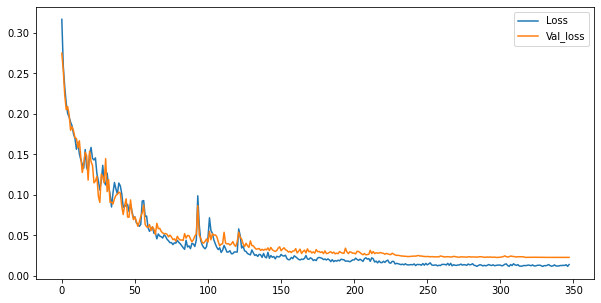

In [ ]:
print("______________ Loss plot of multi CAE + LSTM with 12 months as inputs__________________\n")
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Loss', 'Val_loss']);

In [ ]:
model.save('/content/drive/MyDrive/Wildfires_IRP/model/Multi_CAE_LSTM/multi_CAE_LSTM_12to1.h5')
#model = load_model('/content/drive/MyDrive/Wildfires_IRP/model/Multi_CAE_LSTM/multi_CAE_LSTM_12to1.h5')

In [ ]:
print("Best score : ", model.evaluate(train, ytrain, verbose=0))

Best score :  [0.006927698850631714, 0.006927698850631714]


In [ ]:
predictions = model.predict(val)
print("Shape of the predictions set: ", predictions.shape)
print("Shape of the original test set: ", yval.shape)

Shape of the predictions set:  (157, 1, 60)
Shape of the original test set:  (157, 1, 60)


In [ ]:
pred_train = model.predict(train)

relative_mse_train_nw = [np.linalg.norm(elem2 - elem) / (112*192) for elem, elem2 in zip(pred_train, ytrain)]
relative_mse_train_ow = np.linalg.norm(pred_train - ytrain) / (112*192)
mse_train = mean_squared_error(pred_train.ravel(), ytrain.ravel())
print("___________Training set predictions______________")
print('mse for train dataset: ', np.mean(relative_mse_train_nw))
print('\n Time to train AE: ', round(end - start, 2), 's')

relative_mse_test_nw = [np.linalg.norm(elem2 - elem) / (112*192) for elem, elem2 in zip(predictions, yval)]
relative_mse_test_ow = np.linalg.norm(predictions - yval) / (112*192)
mse_test = mean_squared_error(predictions.ravel(), yval.ravel())
print("\n___________Testing set predictions______________")
print('mse for test dataset: ', np.mean(relative_mse_test_nw))

___________Training set predictions______________
mse for train dataset:  2.0201306342889117e-05

 Time to train AE:  334.29 s

___________Testing set predictions______________
mse for test dataset:  3.332729083574881e-05


In [ ]:
results_multi_CAE_LSTM_12to1 = {'Time for training (s)':  round(end - start, 2),
           'relative mse_test new way':  np.mean(relative_mse_test_nw), 
           'relative mse_train new way': np.mean(relative_mse_train_nw),
           'relative mse_test old way':  relative_mse_test_ow, 
           'relative mse_train old way': relative_mse_train_ow,
           'mse test' : mse_test,
           'mse_train': mse_train
          }

In [ ]:
results_multi_CAE_LSTM_12to1

{'Time for training (s)': 334.29,
 'mse test': 0.0291037,
 'mse_train': 0.006927698,
 'relative mse_test new way': 3.332729083574881e-05,
 'relative mse_test old way': 0.0007699814935525259,
 'relative mse_train new way': 2.0201306342889117e-05,
 'relative mse_train old way': 0.0008929201534816197}

## Table of Results

In [ ]:
pd.set_option('display.float_format', '{:.2e}'.format)

print("______________Results Many - to - One_____________________\n\n")
pd.DataFrame([results_multi_CAE_LSTM_3to3, results_multi_CAE_LSTM_6to6, results_multi_CAE_LSTM_12to12, results_multi_CAE_LSTM_6to1, results_multi_CAE_LSTM_12to1],
             index=['Multi CAE LSTM 3to3','Multi CAE LSTM 6to6', 'Multi CAE LSTM 12to12', 'Multi CAE LSTM 6to1', 'Multi CAE LSTM 12to1']
             ).sort_values('relative mse_test new way')

______________Results Many - to - One_____________________




,Time for training (s),relative mse_test new way,relative mse_train new way,relative mse_test old way,relative mse_train old way,mse test,mse_train
Multi CAE LSTM 6to1,8.38e+01,2.96e-05,1.91e-05,5.77e-04,7.47e-04,1.60e-02,4.76e-03
Multi CAE LSTM 3to3,1.45e+02,3.33e-05,2.02e-05,7.70e-04,8.93e-04,2.91e-02,6.93e-03
Multi CAE LSTM 12to1,3.34e+02,3.33e-05,2.02e-05,7.70e-04,8.93e-04,2.91e-02,6.93e-03
Multi CAE LSTM 6to6,5.30e+02,5.87e-05,4.55e-05,8.44e-04,1.43e-03,5.79e-03,2.94e-03
Multi CAE LSTM 12to12,3.19e+02,1.17e-04,1.05e-04,1.57e-03,3.22e-03,1.04e-02,7.73e-03
